Importing and Loading Training data

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import joblib

# Load dataset
df = pd.read_csv("../data/coupon_data/train.csv")

print(df.shape)
df.head()


(78369, 5)


,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [30]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


Data preprocessing

In [31]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(columns=['redemption_status', 'id'])  # drop id since it's just row index
y = df['redemption_status']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (62695, 3) Val shape: (15674, 3)


Model Training with Class Balancing

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# 1. Logistic Regression (with class_weight balanced)
log_reg_bal = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_bal.fit(X_train, y_train)

# 2. Random Forest (with class_weight balanced)
rf_bal = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_bal.fit(X_train, y_train)

# 3. LightGBM (with is_unbalance=True)
train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

params_bal = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "is_unbalance": True,   # ✅ handle imbalance
    "verbose": -1
}

lgb_bal = lgb.train(
    params_bal,
    train_set,
    valid_sets=[val_set],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)



Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.848545


Evaluation Metrics:

🔹 Logistic Regression (Balanced) Evaluation
AUC: 0.5817

Classification Report:
              precision    recall  f1-score   support

           0     0.9922    0.5439    0.7026     15528
           1     0.0112    0.5479    0.0219       146

    accuracy                         0.5439     15674
   macro avg     0.5017    0.5459    0.3622     15674
weighted avg     0.9831    0.5439    0.6963     15674



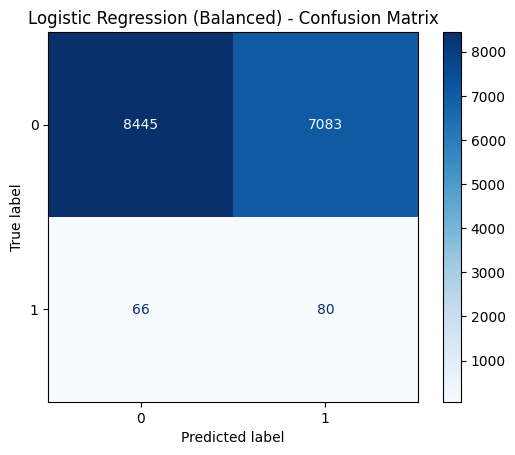

🔹 Random Forest (Balanced) Evaluation
AUC: 0.7347

Classification Report:
              precision    recall  f1-score   support

           0     0.9911    0.9992    0.9951     15528
           1     0.3333    0.0411    0.0732       146

    accuracy                         0.9903     15674
   macro avg     0.6622    0.5202    0.5341     15674
weighted avg     0.9849    0.9903    0.9865     15674



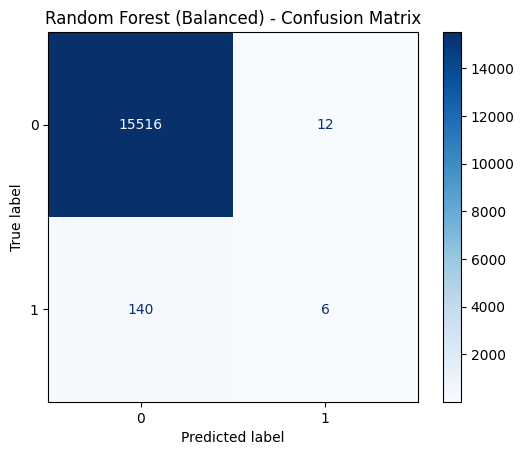

🔹 LightGBM (Balanced) Evaluation
AUC: 0.8485

Classification Report:
              precision    recall  f1-score   support

           0     0.9956    0.8859    0.9376     15528
           1     0.0458    0.5822    0.0849       146

    accuracy                         0.8831     15674
   macro avg     0.5207    0.7341    0.5112     15674
weighted avg     0.9867    0.8831    0.9296     15674



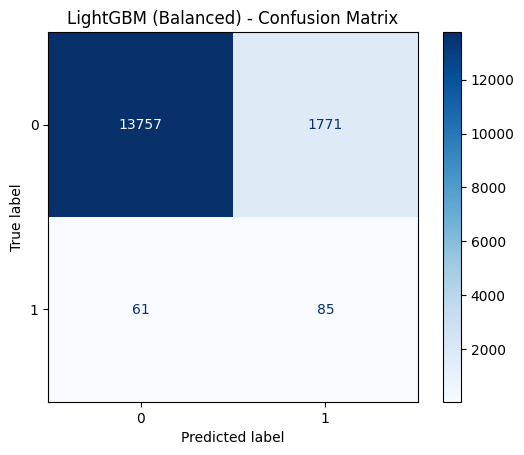

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

models_bal = {
    "Logistic Regression (Balanced)": log_reg_bal,
    "Random Forest (Balanced)": rf_bal,
    "LightGBM (Balanced)": lgb_bal
}

for name, model in models_bal.items():
    print("="*60)
    print(f"🔹 {name} Evaluation")
    print("="*60)

    # Prediction handling
    if "LightGBM" in name:
        y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = (y_pred_proba >= 0.5).astype(int)
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

    # AUC
    auc = roc_auc_score(y_val, y_pred_proba)
    print(f"AUC: {auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, digits=4, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


Comparison table

In [48]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Collect results
results = []

for name, model in models_bal.items():
    if "LightGBM" in name:
        y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = (y_pred_proba >= 0.5).astype(int)
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

    results.append({
        "Model": name,
        "AUC": roc_auc_score(y_val, y_pred_proba),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1-Score": f1_score(y_val, y_pred, zero_division=0)
    })

# Create DataFrame
summary_df = pd.DataFrame(results)
print(summary_df)

# Save to CSV for your repo / presentation
summary_df.to_csv("model_comparison.csv", index=False)


                            Model       AUC  Precision    Recall  F1-Score
0  Logistic Regression (Balanced)  0.581737   0.011169  0.547945  0.021891
1        Random Forest (Balanced)  0.734673   0.333333  0.041096  0.073171
2             LightGBM (Balanced)  0.848545   0.045797  0.582192  0.084915
